In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn import datasets
diabetes_dataset = datasets.load_diabetes()

In [3]:
diabetes_dataset.keys()

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])

In [4]:
# Save the input and target variables

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]
print(data.shape)
print(targets.shape)

(442, 10)
(442,)


In [5]:
type(targets)

numpy.ndarray

In [6]:
# Normalise the target data (this will make clearer training curves)

targets = (targets-targets.mean())/targets.std()

In [7]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data, targets, test_size=0.1)

In [8]:
print(train_data.shape)
print(test_data.shape)

(397, 10)
(45, 10)


#### Train a feedforward neural network model

In [9]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],) ),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1)
    ])
    
    return model

model = get_model()

In [10]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 67,585
Trainable params: 67,585
Non-trainable params: 0
____________________________________________________

In [11]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_labels, epochs=100, validation_split=0.1, batch_size=64)

Train on 357 samples, validate on 40 samples
Epoch 1/100
357/357 [==============================] - 2s 5ms/sample - loss: 0.9842 - mae: 0.8502 - val_loss: 0.8721 - val_mae: 0.7788
Epoch 2/100
357/357 [==============================] - 0s 306us/sample - loss: 0.8512 - mae: 0.7946 - val_loss: 0.7502 - val_mae: 0.7299
Epoch 3/100
357/357 [==============================] - 0s 561us/sample - loss: 0.6496 - mae: 0.6940 - val_loss: 0.5679 - val_mae: 0.6190
Epoch 4/100
357/357 [==============================] - 0s 512us/sample - loss: 0.5469 - mae: 0.6000 - val_loss: 0.9184 - val_mae: 0.7917
Epoch 5/100
357/357 [==============================] - 0s 310us/sample - loss: 0.5464 - mae: 0.5904 - val_loss: 0.5304 - val_mae: 0.5627
Epoch 6/100
357/357 [==============================] - 0s 551us/sample - loss: 0.5123 - mae: 0.5834 - val_loss: 0.6800 - val_mae: 0.6959
Epoch 7/100
357/357 [==============================] - 0s 532us/sample - loss: 0.4866 - mae: 0.5759 - val_loss: 0.5196 - val_mae: 0.571

In [13]:
# Evaluate the model on the test set

model.evaluate(test_data, test_labels, verbose=2)

45/1 - 0s - loss: 0.7403 - mae: 0.6290


[0.6900706768035889, 0.6289561]

#### Plot the learning curves

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

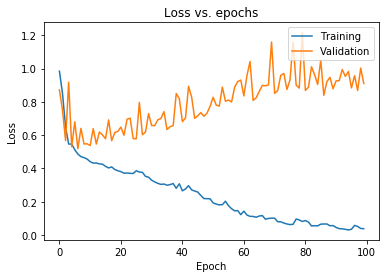

In [15]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [16]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [17]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_regularizer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [18]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5,0.5)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               1408      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [19]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [20]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_labels, epochs=100, validation_split=0.15, batch_size=64)

Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 [==============================] - 3s 8ms/sample - loss: 1.0161 - mae: 0.8590 - val_loss: 0.9911 - val_mae: 0.8243
Epoch 2/100
337/337 [==============================] - 0s 372us/sample - loss: 1.0132 - mae: 0.8588 - val_loss: 0.9897 - val_mae: 0.8259
Epoch 3/100
337/337 [==============================] - 0s 568us/sample - loss: 1.0131 - mae: 0.8605 - val_loss: 0.9876 - val_mae: 0.8273
Epoch 4/100
337/337 [==============================] - 0s 578us/sample - loss: 1.0091 - mae: 0.8607 - val_loss: 0.9836 - val_mae: 0.8275
Epoch 5/100
337/337 [==============================] - 0s 579us/sample - loss: 0.9955 - mae: 0.8562 - val_loss: 0.9757 - val_mae: 0.8239
Epoch 6/100
337/337 [==============================] - 0s 571us/sample - loss: 0.9930 - mae: 0.8572 - val_loss: 0.9595 - val_mae: 0.8195
Epoch 7/100
337/337 [==============================] - 0s 578us/sample - loss: 0.9537 - mae: 0.8427 - val_loss: 0.9221 - val_mae: 0.808

In [21]:
# Evaluate the model on the test set

model.evaluate(test_data, test_labels, verbose=2)

45/1 - 0s - loss: 0.6108 - mae: 0.5307


[0.4963275207413567, 0.53072095]

#### Plot the learning curves

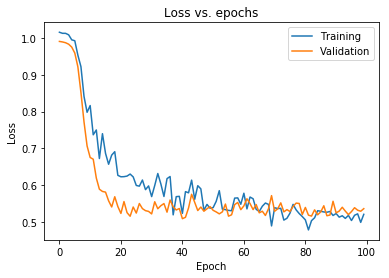

In [22]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [23]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs=None):
        print("Training Started....")
    
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting Epoch: {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting Batch: {batch}")
        
    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finished Batch: {batch}")
        
    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished Epoch: {epoch}")
        
    def on_train_end(self, logs=None):
        print("Training Finished!!")
        

In [24]:
# Re-build the model

model = get_regularised_model(1e-5,0.5)

In [25]:
# Compile the model

model.compile(optimizer="adam", loss="mse")

#### Train the model with the callback

In [27]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_labels, epochs=3, verbose=False, batch_size=128, callbacks=[TrainingCallback()])

Training Started....
Starting Epoch: 0
Training: Starting Batch: 0
Training: Finished Batch: 0
Training: Starting Batch: 1
Training: Finished Batch: 1
Training: Starting Batch: 2
Training: Finished Batch: 2
Training: Starting Batch: 3
Training: Finished Batch: 3
Finished Epoch: 0
Starting Epoch: 1
Training: Starting Batch: 0
Training: Finished Batch: 0
Training: Starting Batch: 1
Training: Finished Batch: 1
Training: Starting Batch: 2
Training: Finished Batch: 2
Training: Starting Batch: 3
Training: Finished Batch: 3
Finished Epoch: 1
Starting Epoch: 2
Training: Starting Batch: 0
Training: Finished Batch: 0
Training: Starting Batch: 1
Training: Finished Batch: 1
Training: Starting Batch: 2
Training: Finished Batch: 2
Training: Starting Batch: 3
Training: Finished Batch: 3
Finished Epoch: 2
Training Finished!!


In [28]:
class TestingCallback(Callback):
    
    def on_test_begin(self, logs=None):
        print("Testing Started....")
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting Batch: {batch}")
        
    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finished Batch: {batch}")
        
    def on_test_end(self, logs=None):
        print("Testing Finished!!")

In [29]:
# Evaluate the model

model.evaluate(test_data, test_labels, verbose=False, callbacks=[TestingCallback()])

Testing Started....
Testing: Starting Batch: 0
Testing: Finished Batch: 0
Testing: Starting Batch: 1
Testing: Finished Batch: 1
Testing Finished!!


0.9831768830617269

In [30]:
class PredictionCallback(Callback):
    
    def on_predict_begin(self, logs=None):
        print("Predictions Started....")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Predicting: Starting Batch: {batch}")
        
    def on_predict_batch_end(self, batch, logs=None):
        print(f"Predicting: Finished Batch: {batch}")
        
    def on_predict_end(self, logs=None):
        print("Predicting Finished!!")

In [31]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Predictions Started....
Predicting: Starting Batch: 0
Predicting: Finished Batch: 0
Predicting: Starting Batch: 1
Predicting: Finished Batch: 1
Predicting Finished!!


array([[0.01425195],
       [0.01698173],
       [0.01599823],
       [0.01441217],
       [0.0134451 ],
       [0.01505692],
       [0.01222451],
       [0.01365995],
       [0.0092686 ],
       [0.00789643],
       [0.0135112 ],
       [0.01195922],
       [0.0155863 ],
       [0.01574984],
       [0.01315708],
       [0.0134835 ],
       [0.0065397 ],
       [0.00997737],
       [0.01568118],
       [0.01168897],
       [0.01175144],
       [0.01199317],
       [0.01591979],
       [0.01432977],
       [0.00974269],
       [0.01551799],
       [0.009859  ],
       [0.01298338],
       [0.01547111],
       [0.01090178],
       [0.01498992],
       [0.01126603],
       [0.00993753],
       [0.01476096],
       [0.01242235],
       [0.01906316],
       [0.00886912],
       [0.01646204],
       [0.01432179],
       [0.01796918],
       [0.01301918],
       [0.01609957],
       [0.00809359],
       [0.0127612 ],
       [0.01487774]], dtype=float32)

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [44]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer="adam", loss="mse")

from tensorflow.keras.callbacks import EarlyStopping

unreg_history = unregularised_model.fit(train_data, train_labels, epochs=100, batch_size=64, verbose=False,
                                        validation_split=0.15, callbacks=[EarlyStopping(patience=3)])

In [45]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_labels, verbose=False)

0.48263845841089886

In [46]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-5,0.5)
regularised_model.compile(optimizer='adam', loss="mse")

reg_history = regularised_model.fit(train_data, train_labels, epochs=100, batch_size=64, verbose=False,
                                     validation_split=0.15, callbacks=[EarlyStopping(patience=3)])

In [47]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_labels, verbose=2)

45/1 - 0s - loss: 0.5610


0.49446488353941176

#### Plot the learning curves

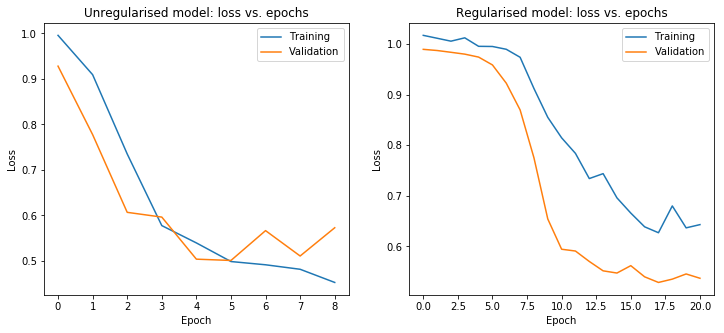

In [48]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()